# Depth-to-normal

Here we explain how depth maps can be converted into surface normal maps. We used the code below to generate the training data.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append('../')

from utils.projection import intrins_to_intrins_inv, get_cam_coords
from utils.visualize import normal_to_rgb
from utils.d2n.cross import d2n_tblr
from utils.d2n.plane_svd import Depth2normal as d2n_svd

Let's first define a sample. 

Here is an image from the [TartanAir](https://theairlab.org/tartanair-dataset/) dataset (scene_name: oldtown).

Note that we are not using the image, but only the depth map.

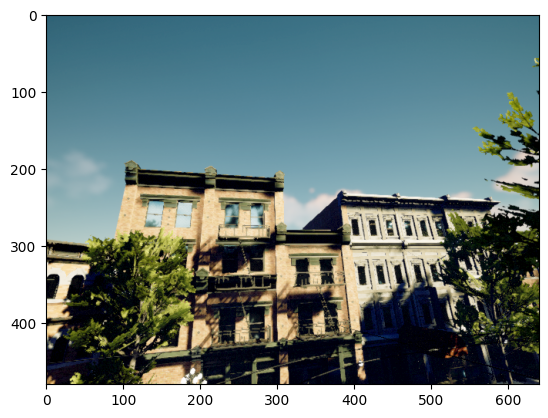

In [2]:
img = Image.open('./example/000000_img.png')
plt.imshow(img)

Here is the corresponding depth map.

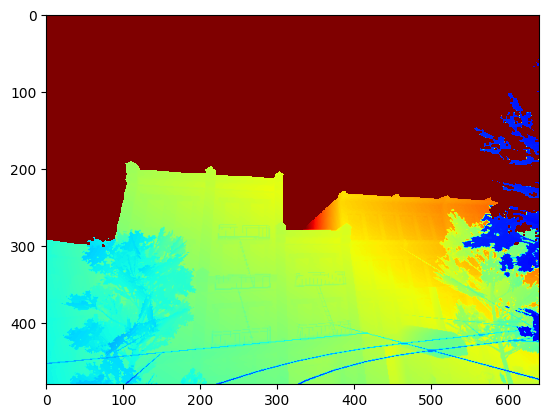

In [3]:
depth = np.load('./example/000000_depth.npy').astype(np.float32)
plt.imshow(depth, cmap='jet', vmin=0.0, vmax=30.0)

Convert the depth map into torch tensor.

In [4]:
# depth should be a torch tensor of shape (1, 1, H, W)
depth = depth[:, :, None]                                       # (H, W, 1)
depth = torch.from_numpy(depth).permute(2, 0, 1).unsqueeze(0)   # (1, 1, H, W)
depth = depth.to(0)

We now need the camera intrinsics.

To be more precise, we need its **inverse** to convert pixel coordinates to 3D camera coordinates.

In [5]:
intrins = np.load('./example/000000_intrins.npy')
intrins_inv = intrins_to_intrins_inv(intrins)
intrins_inv = torch.from_numpy(intrins_inv).unsqueeze(0).to(0)

Now, compute the 3D camera coordinates.

In [6]:
points = get_cam_coords(intrins_inv, depth)

You now have two options:

### Option 1. Do a cross-product

The easiest way to compute the normal vectors would be to do a cross product between two tangential vectors.

In [7]:
normal, valid_mask = d2n_tblr(points, k=5, d_min=1e-3, d_max=1000.0)

* `normal`: tensor of surface normal vectors, shape: (B, 3, H, W)
* `valid_mask`: boolean tensor of shape (B, 1, H, W), True for pixels with valid surface normal

We can now visualize the surface normals in RGB

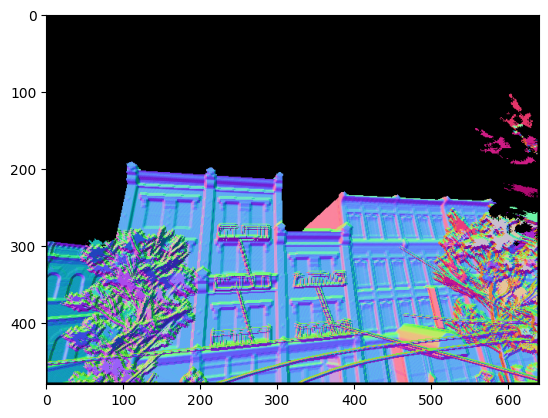

In [8]:
normal_rgb = normal_to_rgb(normal, valid_mask)[0, ...]
plt.imshow(normal_rgb)

### Option 2. Do PlaneSVD

Or we can do PlaneSVD. 

We can filter out nghbr pixels if their depth is largely different from the center pixel. This can improve the quality of the computed normals near depth discontinuities.

In [9]:
with torch.no_grad():
    D2N = d2n_svd(d_min=1e-3, d_max=1000.0, k=5, d=1, gamma=0.05, min_nghbr=4)
    normal, valid_mask = D2N(points)

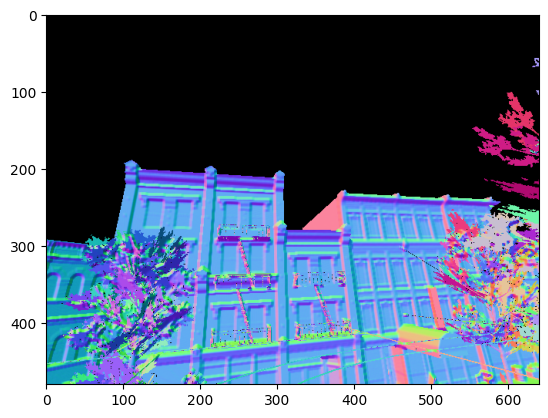

In [10]:
normal_rgb = normal_to_rgb(normal, valid_mask)[0, :, ...]
plt.imshow(normal_rgb)

### Saving the normals

You can try saving the normals in `float32` numpy array, but the file size would be too big.

If the normals are not so accurate, you can quantize them and save as `uint8` or `uint16`. See `normal_to_uint8` and `normal_to_uint16` in `utils/visualize.py`

If the normals are very accurate (e.g. because it is from a synthetic dataset), you might wanna keep the precision. In such a case, we used `.exr` format:

```
normal = normal * valid_mask
normal = normal.detach().cpu().permute(0, 2, 3, 1).numpy().astype(np.float32)
normal = normal[0, ...]
cv2.imwrite(target_path, cv2.cvtColor(normal, cv2.COLOR_RGB2BGR))
```